In [164]:
import time
import glob
import math
import pathlib
import datetime
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from keras import layers

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

In [165]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


In [5]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, augmentation=None, preprocessing=None, shuffle=False, verbose=0, maxbatches=None, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.maxbatches = maxbatches
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        if self.maxbatches:
            return min(self.maxbatches, math.ceil(len(self.ids) / self.batch_size))
        else:
            return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = np.array(Image.open(f"{source_id}.png"))            
            y = np.array(Image.open(f"{source_id}_labels.png"))
            
            if self.augmentation:
                augmented = self.augmentation(image=x, mask=y)
                x, y = augmented['image'], augmented['mask']
                
            if self.preprocessing:
                x = self.preprocessing(x)
              
            images.append(x/255.0) # normalize between 0 and 1 at the same time
            #labels.append(y)
            labels.append(keras.utils.to_categorical(y, 8))
         
        return np.array(images, dtype=float), np.array(labels, dtype=float)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

In [6]:
def compare_segmentations(img_source, mask_source, predictions):
    
    mask = np.argmax(predictions, axis=3)[0]
    
    fig = plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(img_source)
    plt.axis('off')
    plt.title("Source")

    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title("Predicted mask")

    plt.subplot(1,3,3)
    plt.imshow(mask_source)
    plt.axis('off')
    plt.title("Original mask")
    
    plt.tight_layout()
    plt.show()

In [7]:
transform2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=[-0.2, 0.2],
            contrast_limit=0.2,
            p=0.5,
        ),
        A.RandomGamma(p=0.5),
    ],
    p=0.8,
    ),
])

In [96]:
#model_name = "LinkNet-efficientnetb7_with_data_augmentation_2_diceLoss"
#model_name = "LinkNet-resnet152_with_data_augmentation_2_diceLoss"
#model_name = "FPN-efficientnetb7_with_data_augmentation_2_diceLoss"
model_name = "FPN-efficientnetb7_with_data_augmentation_2_diceLoss_512x256"

In [97]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [98]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Chargons le modèle à tester

In [99]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

### Evaluons sur le validation set

In [100]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 138s 2s/step - loss: 0.1663 - iou_score: 0.7326 - f1-score: 0.8334
inference time (500 samples): 138.16s


### Testons une prédiction sans préprocessing (pour voir...)

In [166]:
test_img = Image.open("data/preprocessed/512x256/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/512x256/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [167]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 3s 3s/step
Inference time: 3.20s


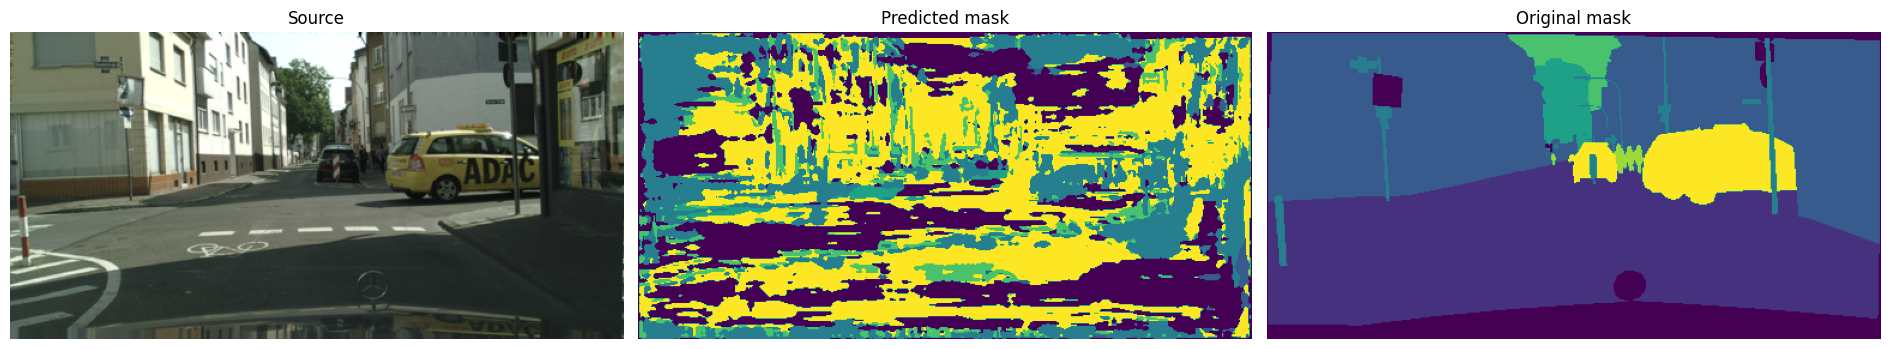

Test avec une image en résolution 512x256. IoU=0.02764343097805977
----------------------------------------------------------------------------------------------------



In [168]:
compare_segmentations(test_img, test_mask, predict)
y_true = np.array([keras.utils.to_categorical(test_mask, 8)])
y_pred = np.array([keras.utils.to_categorical(np.argmax(predict, axis=3)[0], 8)])
print(f"Test avec une image en résolution 512x256. IoU={sm.metrics.iou_score(y_true, y_pred)}\n{'-'*100}\n")

### Test de prédiction avec préprocessing (mais en fournissant au modèle l'image en différentes résolutions pour voir ce qui se passe)

In [169]:
files_path = pathlib.Path('data', 'preprocessed', "256x128", "val")
ids = []
for x in files_path.glob("*_labels.png"):
    path = str(x)
    file = path[path.rfind('/')+1:-11]
    ids.append(file)

munster_000013_000019
1/1 [==============================] - 1s 979ms/step


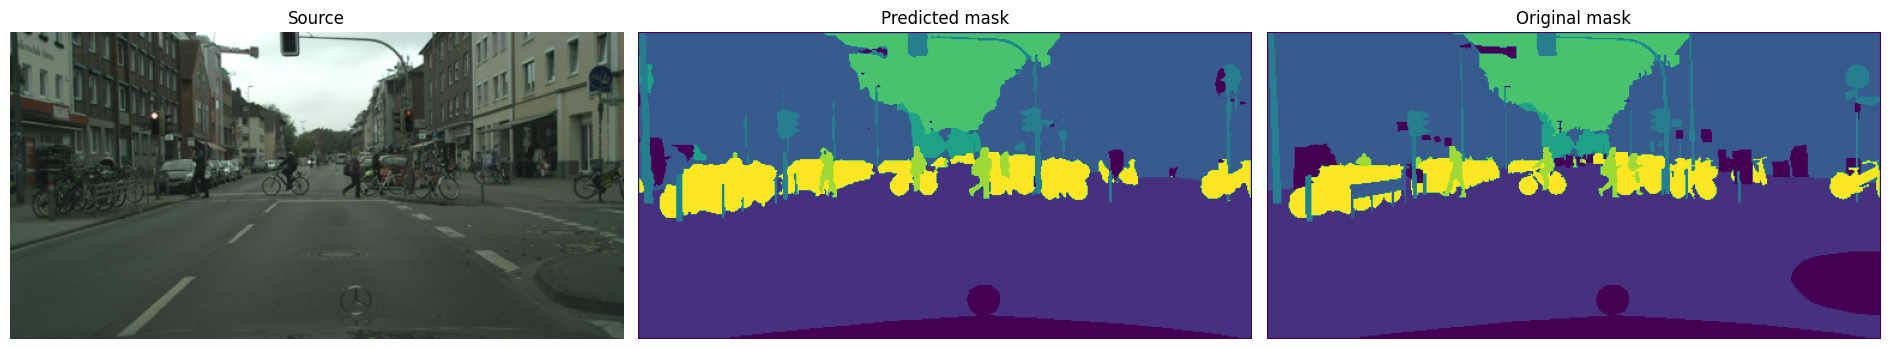

Test avec une image en résolution 512x256. IoU=0.7665128707885742
----------------------------------------------------------------------------------------------------

1/1 [==============================] - 0s 295ms/step


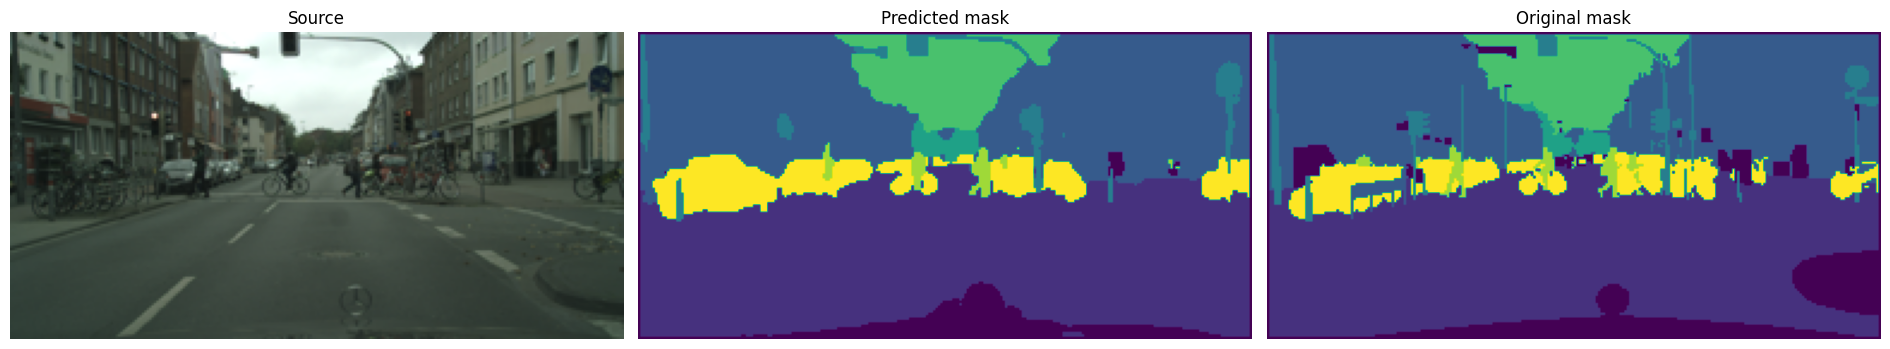

Test avec une image en résolution 256x128. IoU=0.6895299553871155
----------------------------------------------------------------------------------------------------

1/1 [==============================] - 4s 4s/step


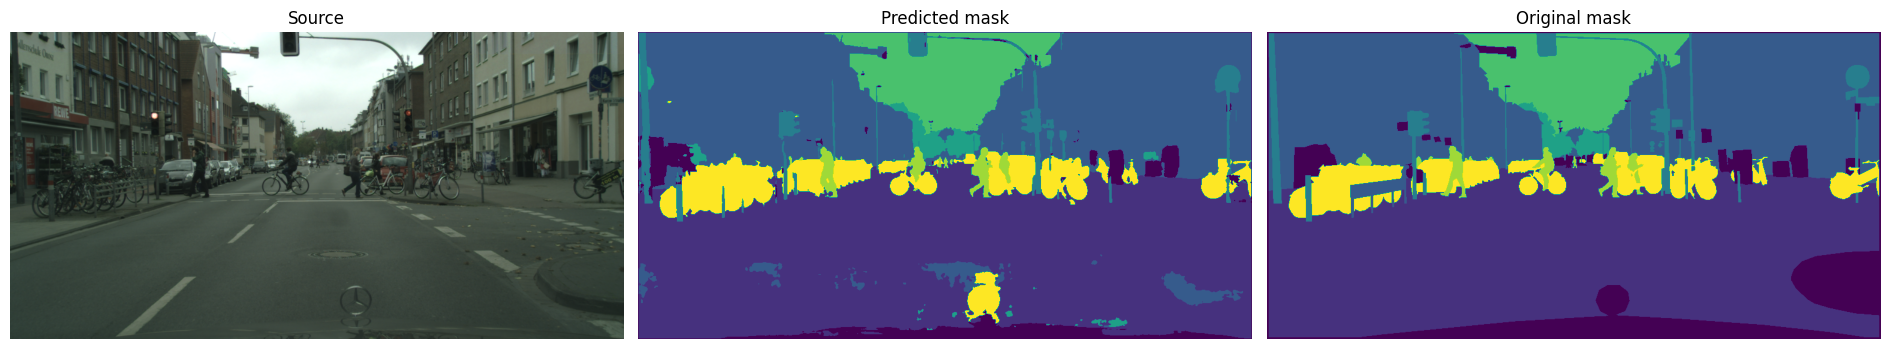

Test avec une image en résolution 1024x512. IoU=0.722025990486145
----------------------------------------------------------------------------------------------------



In [172]:
def preprocess_sample(img, preprocessing=None):
    
    x = np.array(img)                
    if preprocessing:
        x = preprocessing(x)
         
    return np.array([x/255], dtype=float)


# Test avec les 512x256
test_id = random.sample(ids, 1)[0]
print(test_id)
test_img = Image.open(str(pathlib.Path('data','preprocessed', '512x256', 'val', f"{test_id}.png")))
test_mask = Image.open(str(pathlib.Path('data','preprocessed', '512x256', 'val', f"{test_id}_labels.png")))

preprocessed_img = preprocess_sample(test_img, preprocess_input)

predict = model.predict(np.array(preprocessed_img))
compare_segmentations(test_img, test_mask, predict)

y_true = np.array([keras.utils.to_categorical(test_mask, 8)])
y_pred = np.array([keras.utils.to_categorical(np.argmax(predict, axis=3)[0], 8)])
print(f"Test avec une image en résolution 512x256. IoU={sm.metrics.iou_score(y_true, y_pred)}\n{'-'*100}\n")


# Test avec les 256x128
test_img = Image.open(str(pathlib.Path('data','preprocessed', '256x128', 'val', f"{test_id}.png")))
test_mask = Image.open(str(pathlib.Path('data','preprocessed', '256x128', 'val', f"{test_id}_labels.png")))

preprocessed_img = preprocess_sample(test_img, preprocess_input)

predict = model.predict(np.array(preprocessed_img))
compare_segmentations(test_img, test_mask, predict)

y_true = np.array([keras.utils.to_categorical(test_mask, 8)])
y_pred = np.array([keras.utils.to_categorical(np.argmax(predict, axis=3)[0], 8)])
print(f"Test avec une image en résolution 256x128. IoU={sm.metrics.iou_score(y_true, y_pred)}\n{'-'*100}\n")


# Test avec les 1024x512
test_img = Image.open(str(pathlib.Path('data','preprocessed', '1024x512', 'val', f"{test_id}.png")))
test_mask = Image.open(str(pathlib.Path('data','preprocessed', '1024x512', 'val', f"{test_id}_labels.png")))

preprocessed_img = preprocess_sample(test_img, preprocess_input)

predict = model.predict(np.array(preprocessed_img))
compare_segmentations(test_img, test_mask, predict)

y_true = np.array([keras.utils.to_categorical(test_mask, 8)])
y_pred = np.array([keras.utils.to_categorical(np.argmax(predict, axis=3)[0], 8)])
print(f"Test avec une image en résolution 1024x512. IoU={sm.metrics.iou_score(y_true, y_pred)}\n{'-'*100}\n")